In [1]:
import matplotlib.pyplot as plt
import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences
import numpy as np
import numpy.ma as ma  
import pandas as pd
import random
import seaborn as sns
from joblib import load
from sklearn.model_selection import train_test_split
import amp.data_utils.data_loader as data_loader
from amp.config import MIN_LENGTH, MAX_LENGTH
from amp.data_utils.sequence import pad, to_one_hot

seed = 7

sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})

params = {'axes.labelsize': 6,'axes.titlesize':6, 'font.size': 6, 'legend.fontsize': 5, 'xtick.labelsize': 6, 'ytick.labelsize': 6}
plt.rcParams.update(params)

Using TensorFlow backend.


In [2]:
def translate_generated_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el - 1] if el != 0 else "" for el in encoded_peptide.argmax(axis=1)])

def translate_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el-1] if el != 0 else "" for el in encoded_peptide])


# Amino acid composition

In [3]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

model_labels = [
    'HydrAMP',
    'PepCVAE',
    'Basic'
]

hydra_color = '#B80018'
pepcvae_color = '#1d3557'
basic_color = '#B4C5E4'

In [4]:
def select_peptides(results, mode):
    if mode=='pos':
        peptides = np.array(results[f'pos_peptides']).reshape(64, -1).T
        amp = (results['pos_class_prediction'] < 0.8).reshape(64, -1)
        mic = results['pos_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmax(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['pos_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['pos_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )
    else:
        peptides = np.array(results['neg_peptides']).reshape(64, -1).T
        amp = (results['neg_class_prediction'] > 0.2).reshape(64, -1)
        mic = results['neg_mic_prediction'].reshape(64, -1)
        combined = ma.masked_where(amp, mic)
        good = combined.argmin(axis=0)
        good_peptides = peptides[list(range(peptides.shape[0])), good]
        good_amp = np.array(results['neg_class_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        good_mic = np.array(results['neg_mic_prediction']).reshape(64, -1).T[list(range(peptides.shape[0])), good]
        return pd.DataFrame.from_dict({
            'sequence': good_peptides.tolist(), 
            'amp': good_amp.tolist(),
            'mic': good_mic.tolist(),
        }
        )

In [5]:
random.seed(seed)
data_manager = data_loader.AMPDataManager(
    '../../data/unlabelled_positive.csv',
    '../../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
amp_x_train, amp_x_test, amp_y_train, amp_y_test = train_test_split(amp_x, amp_y, test_size=0.1, random_state=36)
amp_x_train, amp_x_val, amp_y_train, amp_y_val = train_test_split(amp_x_train, amp_y_train, test_size=0.2, random_state=36)


# Restrict the length
ecoli_df = pd.read_csv('../../data/mic_data.csv')
mask = (ecoli_df['sequence'].str.len() <= MAX_LENGTH) & (ecoli_df['sequence'].str.len() >= MIN_LENGTH)
ecoli_df = ecoli_df.loc[mask]
mic_x = pad(to_one_hot(ecoli_df['sequence']))
mic_y = ecoli_df.value

mic_x_train, mic_x_test, mic_y_train, mic_y_test = train_test_split(mic_x, mic_y, test_size=0.1, random_state=36)
mic_x_train, mic_x_val, mic_y_train, mic_y_val = train_test_split(mic_x_train, mic_y_train, test_size=0.2, random_state=36)


pos = np.vstack([amp_x_test[amp_y_test == 1], mic_x_test[mic_y_test < 1.5]])
neg = np.vstack([amp_x_test[amp_y_test == 0], mic_x_test[mic_y_test > 1.5]])
positives = random.sample([translate_peptide(x) for x in pos], 1253)
negatives = [translate_peptide(x) for x in neg]

# Load Uniprot
uniprot = list(pd.read_csv('../../data/Uniprot_0_25_test.csv').Sequence)
uniprot = random.sample(uniprot, 1253)


# Get random peptides
random_gen = modlamp.sequences.Random(1253, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


/home/paulina/miniconda3/envs/hydramp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/paulina/miniconda3/envs/hydramp/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [6]:
hydra_results = load(f'../../results/unconstrained_{models[0]}.joblib')
pepcvae_results = load(f'../../results/unconstrained_{models[1]}.joblib')
basic_results = load(f'../../results/unconstrained_{models[2]}.joblib')

In [7]:
hydra_positives = select_peptides(hydra_results, 'pos').sequence.tolist()
hydra_negatives = select_peptides(hydra_results, 'neg').sequence.tolist()

pepcvae_positives = select_peptides(pepcvae_results, 'pos').sequence.tolist()
pepcvae_negatives = select_peptides(pepcvae_results, 'neg').sequence.tolist()

basic_positives = select_peptides(basic_results, 'pos').sequence.tolist()
basic_negatives = select_peptides(basic_results, 'neg').sequence.tolist()

In [8]:
def get_aa_composition(data):
    STD_AA = list('ACDEFGHIKLMNPQRSTVWY')
    seq = ''.join(data)
    count = len(seq)

    aa_comp = {}
    for aa in STD_AA:
        aa_comp[aa] = seq.count(aa) / count
    return aa_comp

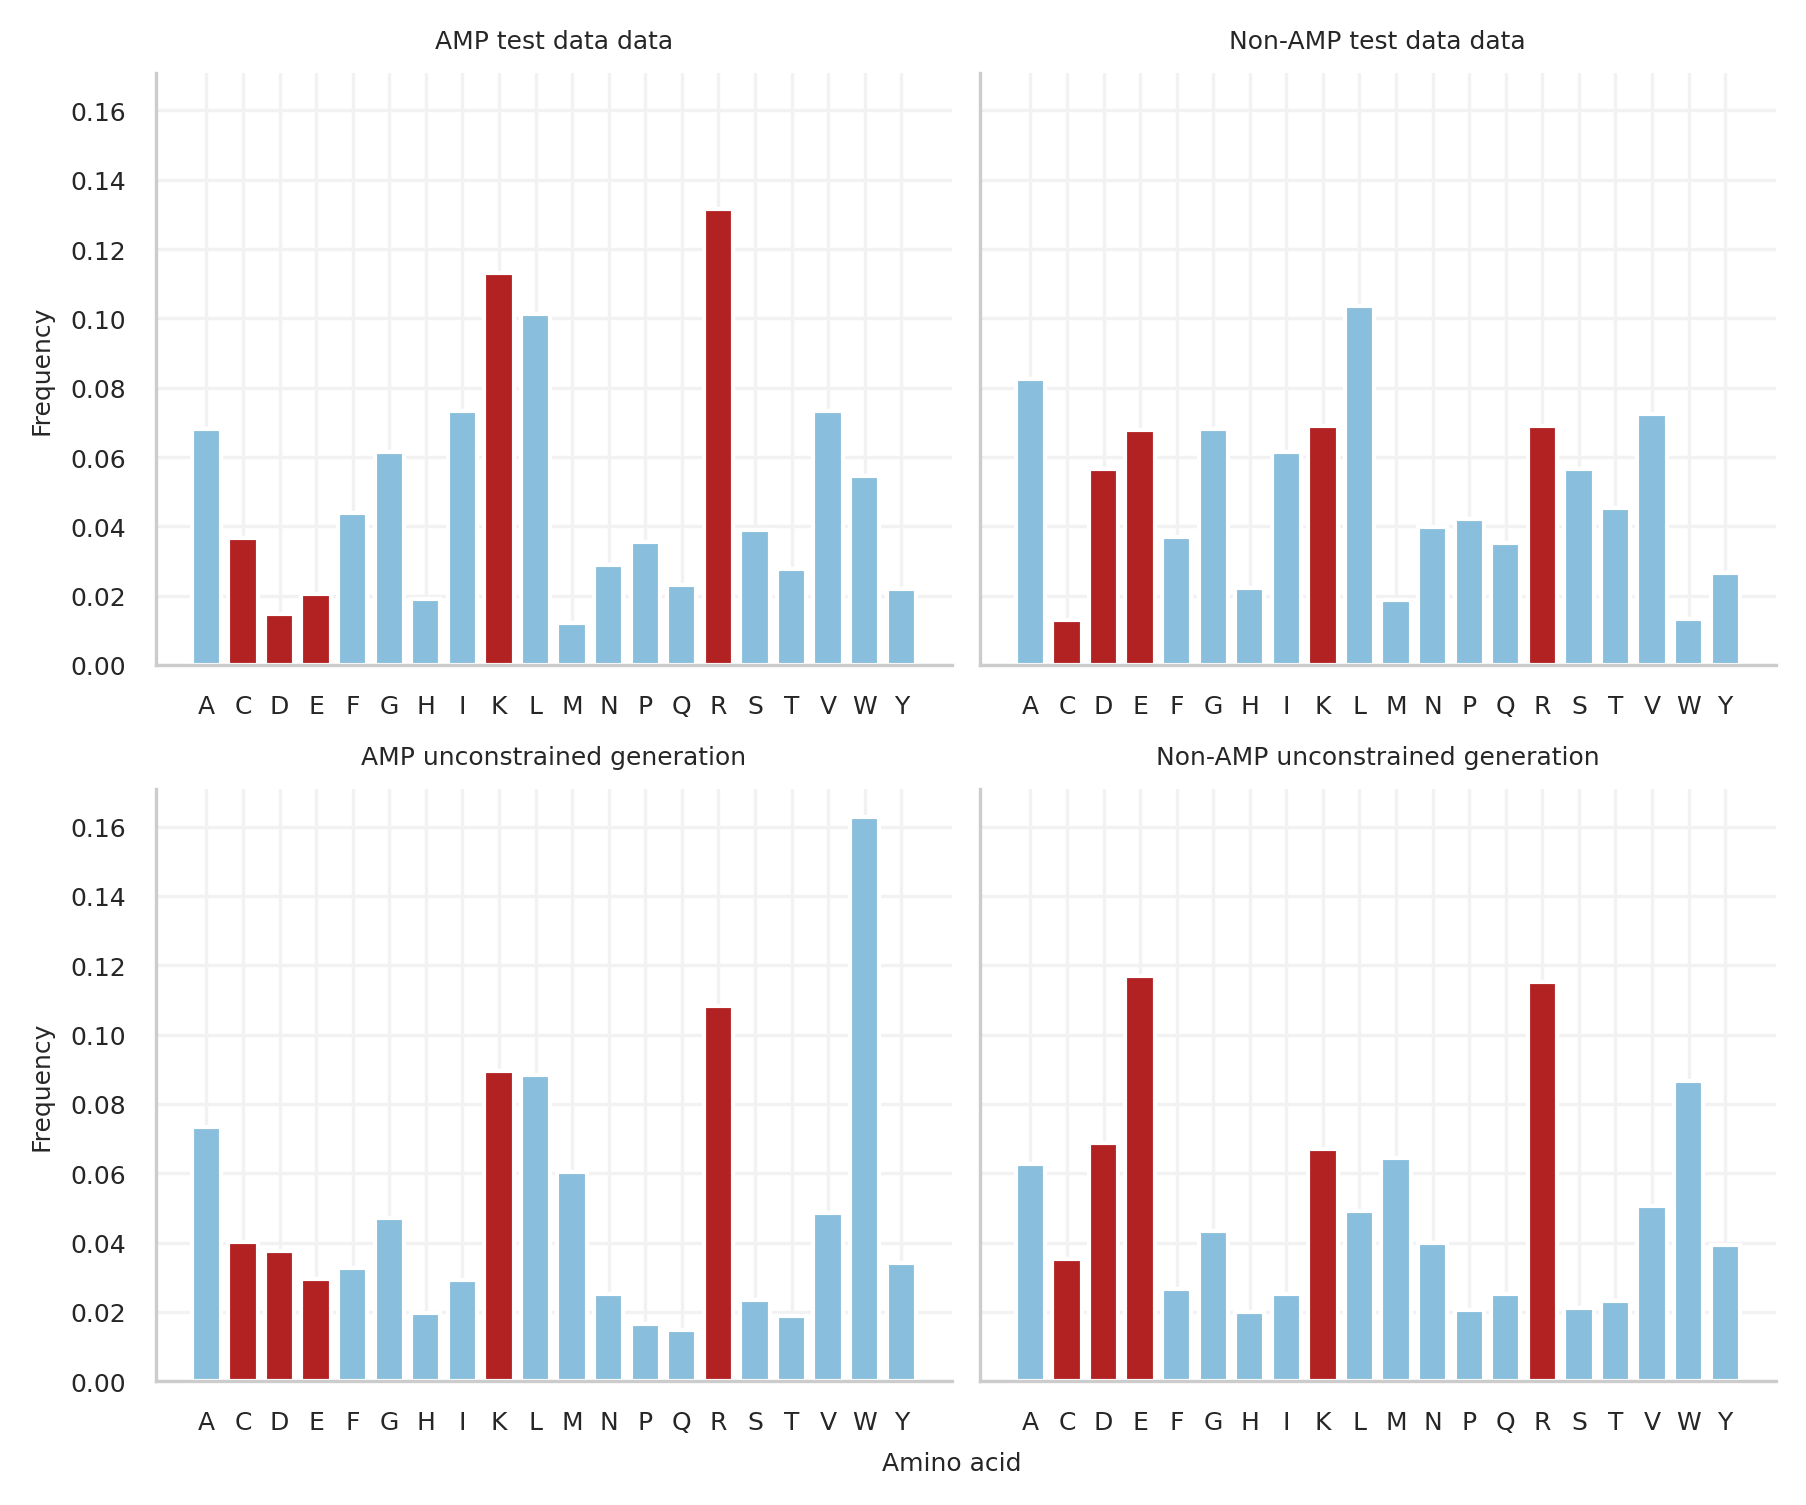

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(6,5), dpi=300, sharey='all')
aa_dict = {}
for i, (ax, data, title) in enumerate(zip(
    [ax1, ax2, ax3, ax4],
    [positives, negatives, hydra_positives, hydra_negatives],
    ['AMP test data data', 'Non-AMP test data data', 'AMP unconstrained generation', 'Non-AMP unconstrained generation']
    )):
    aa_composition = get_aa_composition(data)
    aa_dict[f'{title}'] = aa_composition
    clrs = ['firebrick' if (x in ['K', 'E', 'C', 'R', 'D']) else '#89bedc' for x in list(aa_composition.keys())]
    ax.bar(x=list(aa_composition.keys()), height=list(aa_composition.values()), color=clrs)
    ax.set_title(title)

ax1.set_ylabel('Frequency')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Amino acid', x=1)
fig.tight_layout()
plt.savefig("../../figures/SuppFig_aacomposition.svg")

In [19]:
df = pd.DataFrame.from_dict(aa_dict)
df.to_csv('Supp_SourceData_FigureS2.csv')